In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# モデルから生成へ

## データ収集

数多くのプロジェクトでは、必要なデータはすべてオンライン上で見つけられることがある。この章で完成させるプロジェクトは、「クマ識別機」だ。グリズリーベア、ブラックベア、テディベアの3種類の熊を識別する。インターネット上には、各種類のクマの画像がたくさん存在し利用することができる。そしてそれを見つけてダウンロードする方法が必要だ。そのために使えるツールを用意したので、この章を参考にして興味のある種類の画像認識Appを自作してみてほしい。fast.aiのコースでは、トリニダードに生息するハチドリの種類からパナマにあるバスの種類まで、何千人もの生徒がコースフォーラムで作品を発表している。ある生徒は、クリスマス休暇中に彼の婚約者が計16人のいとこを識別できるようにするアプリケーションを作成した！


執筆時点でBing画像検索は、画像を検索してダウンロードするための最良の選択肢だ。月に1,000回まで無料で利用でき、1回の検索で最大150枚の画像をダウンロードすることができる。しかし私たちがこれを書いたときより、あなたがこの本を読んでいるときの方がもっと良いものが登場しているかもしれない。よって現在のおすすめは、[本のウェブサイト](https://book.fast.ai/)で確認してほしい。

> [重要事項] 最新のサービスに触れる： データセットの作成に利用できるサービスは常に生まれては消え、その機能・インターフェース・価格も定期的に変化している。このセクションでは、本書が執筆された時点で利用可能なBing Image Search APIの使用方法を紹介する。[本書のウェブサイト](https://book.fast.ai/)では、より多くの選択肢と最新の情報を提供しているので、ディープラーニング用のデータセットを作成するためにウェブから画像をダウンロードする方法に関する最新の情報を得るために是非一読願いたい。

# データクリーニング
Bing Image Searchで画像をダウンロードするには、Microsoft Azureで無料アカウントにサインアップする必要がある。キーが配布されるので、それをコピーして以下のようにセルに入力する。（「XXX」を自分のキーに置き換えて実行）：

※柴田注 Azureを使ったことない人はここで少し手詰まるかもしれないので忘備録

1.   アカウント登録が終わるとポータルのホーム画面に行く
2.   左上のリソース作成
1.   Bing Search v7を作成
2.   価格レベルはF1(無料プラン)を選択して作成
1.   リソースページのキーとエンドポイントへ移動
2.   キーをコピー(2つのうちどちらでもOK)

<img src="https://drive.google.com/uc?id=1Iwo9RS7IRSrAn4g9GsXUfpMnG3dOvwsX" width='500'>
<img src="https://drive.google.com/uc?id=1zfEYb8KZfdl6W5VkaYMcDWk0-lWKBDF-" width='500'>
<img src="https://drive.google.com/uc?id=1ulDwQc8lyu7muj4VBt8dJdDKmu6ONISC" width='500'>
<img src="https://drive.google.com/uc?id=1LXeZV5JBjFXnuygjr7zRIOQYUAPJ_t1e" width='500'>


In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a81ed106434d4515902599175149c81b')

また、コマンドラインに慣れている人はターミナルで次のように設定することもできる：

    export AZURE_SEARCH_KEY=your_key_here

上記コードを実行してJupyter Notebookを再起動し、編集せずに使用する。

`key`を設定したら、`search_images_bing`を使用することができる。この関数はオンラインのノートブックに含まれている`utils` クラスで提供されている。もし、ある関数がどこで定義されているかわからない場合は、ノートブックにその関数を入力すればわかるようになっている：

In [ ]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

149

150のグリズリーベア（少なくとも、Bing Image Searchがその単語で見つけられる画像）のURLをダウンロードすることに成功した。

(※柴田注 御覧の通り5/17時点では計149枚になっている)

**注意**：このような検索でどのような画像が見つかるか、正確に確認する方法はない。検索結果は時間の経過とともに変化するからである。少なくとも1件、コミュニティメンバーが検索結果に熊の死体の不快な写真を見つけたと聞いている。ウェブ検索エンジンが見つけた画像はすべてあなたに届く。もしあなたが仕事場や子供と一緒にこれを実行しているならば、ダウンロードした画像を表示する前に慎重になる必要があるかもしれない。

では1つ見てみることにしよう：

In [7]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

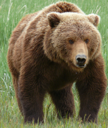

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

それでは、fastaiの`download_images`を使って、各検索語のURLをすべてダウンロードし、それぞれを別のフォルダに入れることにする：

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

フォルダには、予想通り画像ファイルがある：

In [12]:
fns = get_image_files(path)
fns

(#433) [Path('bears/grizzly/65f07f77-d9bf-4b7a-913e-e7e6f6604ce4.jpg'),Path('bears/grizzly/b03136cb-b87c-4fd3-a058-ff50afea2589.jpg'),Path('bears/grizzly/bcf7bb81-b818-4091-b512-3122e3ef0a00.jpg'),Path('bears/grizzly/979ee7a0-872a-467d-a0d2-e21df1d83e21.jpg'),Path('bears/grizzly/b88bb7bc-4462-4103-bbcc-9c3b1f033c84.jpg'),Path('bears/grizzly/350f995e-0f90-43c7-a576-0b183cba482e.jpg'),Path('bears/grizzly/c6e25e37-0187-4a74-ba0e-a419d6b2557a.jpg'),Path('bears/grizzly/aabbc77b-7b1f-4c11-8805-9dd51f98f704.jpg'),Path('bears/grizzly/982a7848-f320-48f5-b31a-23a2a4f9fefd.jpg'),Path('bears/grizzly/ef09fce4-25ef-4668-85b8-65714ef89642.jpg')...]

> j：Jupyterノートブックで作業することについては、この点がとても気に入っている。自分の好きなものを少しずつ作って、その都度チェックできるのはとても楽なのだ。私は失敗が多いので、これは本当に助かる...。

インターネットからファイルをダウンロードしたとき、破損しているものがいくつかあることがよくあるため、確認してみる：

In [13]:
failed = verify_images(fns)
failed

(#16) [Path('bears/grizzly/266d6a9d-3543-4b7a-8897-ced56335b26f.jpg'),Path('bears/grizzly/9adf0e2d-785d-4497-a680-ee41bbc0fe16.jpg'),Path('bears/grizzly/e821c3cb-c58d-4013-a362-230914cd7c40.jpg'),Path('bears/teddy/f2698f6a-d3ea-4116-ab73-54b8bb36d06a.JPG'),Path('bears/teddy/85a415da-5579-4f63-b5b8-a84e6adbc6e6.jpg'),Path('bears/teddy/7fdd5ae2-8adf-4c0e-869f-acb78d55bdfc.jpg'),Path('bears/teddy/eecb999c-b793-45a6-bd14-a6bd09146378.JPG'),Path('bears/teddy/787df5e1-e43a-4718-ad30-8e1fcf5e06e6.JPG'),Path('bears/teddy/93fdc409-9a3d-4bdc-a66f-b29e727bb727.JPG'),Path('bears/teddy/e31e8afe-4782-4252-9488-cbad513349c3.jpg')...]

破損した画像をすべて削除するには、それぞれの画像に対して `unlink` を使用することができる。コレクションを返す多くの fastai 関数と同様に、 `verify_images` は `L` 型のオブジェクトを返し、その中に `map` メソッドが含まれていることに注意してほしい。これは、コレクションの各要素に対して渡された関数を呼び出すものである：

In [14]:
failed.map(Path.unlink);

### 補足：Jupyter Notebooksでヘルプを得る

Jupyter Notebooksは、各関数の結果をすぐに確認できる実験に最適だが、様々な関数の使い方を考えたり、そのソースコードを直接見たりするための機能も充実している。例えば、セルに以下を入力すると
```
??verify_images
```
下のようなウィンドウがポップアップする：
```
Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in
             enumerate(parallel(verify_image, fns)) if not o)
File:      ~/git/fastai/fastai/vision/utils.py
Type:      function
```
この関数はどのような引数（`fns`）を受け取るかを教えてくれ、次にソースコードとその元となるファイルを示してくれる。このソースコードを見ると、関数 `verify_image` を並列に適用し、その結果が `False` である画像ファイルのみを保持していることがわかるだろう。これは doc の文字列と一致しており、`fns` にある画像を開くことができないものを見つけているのだ。

その他、Jupyterノートブックで非常に便利な機能をいくつか紹介しよう：

- 関数や引数名の正確なスペルを覚えていない場合、Tabキーを押すことで自動補完候補を表示することができる。
- 関数の括弧の中にいるとき、ShiftとTabを同時に押すと、関数のシグネチャーと短い説明を表示するウィンドウが表示される。これらのキーを2回押すとドキュメントが拡大され、3回押すと同じ情報を含むフルウィンドウが画面の下に表示される。
- セル内で `?func_name` と入力して実行すると、関数のシグネチャと短い説明の入ったウィンドウが開く。
- セル内で、`??func_name`と入力して実行すると、関数のシグネチャーと短い説明、そしてソースコードが表示されるウィンドウが表示される。
- セル内で `doc(func_name)` を実行すると、関数のシグネチャ、短い説明、GitHub上のソースコードへのリンク、そして [library docs](https://docs.fast.ai) にある関数の完全なドキュメントが表示されたウィンドウが開かれる。
- ドキュメントとは関係はないが非常に便利であるのが、エラーが発生したときにいつでもヘルプを得るために、次のセルに `%debug` と入力して実行すると [Python debugger](https://docs.python.org/3/library/pdb.html) が開かれ、すべての変数の中身を調べることができる。

### 補足終了

このプロセスで注意しなければならないのは、<<chapter_intro>>で説明したように、モデルは訓練に使われたデータしか反映できないことである。そして、世の中には偏ったデータが溢れており、例えばBing画像検索（今回のデータセット作成に使用したもの）にも反映されてしまう。例えば、ユーザーが健康な肌かどうかを知るためのアプリを作りたいと考え、"healthy skin "の検索結果でモデルを学習させたとしましょう。<<healthy_skin>>でどのような結果を得ることができるか見てほしい。

<img src="https://github.com/fastai/fastbook/blob/master/images/healthy_skin.gif?raw=1" width="600" caption="Data for a healthy skin detector?" id="healthy_skin">

これを学習データとして使用すると、健康な肌の検出器ではなく、*若い白人女性が顔を触っている*検出器になってしまう！あなたのアプリケーションで実際に目にする可能性のあるデータの種類をよく考え、これらの種類がすべてモデルのソースデータに反映されていることを慎重に確認してほしい。 脚注：[「健康な肌」の例を思いついたDeb Rajiに感謝する。彼女の論文[Actionable Auditing: Investigating the Impact of Publicly Naming Biased Performance Results of Commercial AI Products"](https://dl.acm.org/doi/10.1145/3306618.3314244)を参照すると、モデルの偏りに関するより魅力的な洞察を得ることができる]。

さてデータをダウンロードを終えたので、モデルのトレーニングに適した形式に組み立てる必要がある。fastaiでは、`DataLoaders`と呼ばれるオブジェクトを作成することになる。

## データをデータローダーへ

`DataLoaders`は薄いクラスで、渡された `DataLoader` オブジェクトを保存し、`train` と `valid` として利用できるようにする。非常にシンプルなクラスだが、fastaiでは非常に重要なクラスである：これはモデルに対してデータを提供する。`DataLoaders`の主要な機能は、この4行のコードだけで提供される（他にも細かい機能があるが今は省略する）：

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> 実は： データローダーはFastaiクラスの一種。渡された複数のDataLoaderオブジェクト（通常はtrainとvalid）を格納するクラスで、好きなだけ持つことができる。最初の2つはプロパティとして利用可能。

この本の後半では、同じ関係を持つ `Dataset` クラスと `Datasets` クラスについても学ぶ。

ダウンロードしたデータを `DataLoaders` オブジェクトに変換するためには、少なくとも4つのことをfastaiに伝える必要がある：

- どのようなデータを扱っているか
- アイテム一覧の取得方法
- これらのラベルの貼り方について
- 検証セットの作成方法

これまでこういった特定の組み合わせのための*ファクトリーメソッド*をいくつか見てきたが、これは、アプリケーションとデータ構造が、たまたまこれらの定義済みメソッドに適合する場合に便利である。そうでない場合、fastaiには*data block API*という非常に柔軟なシステムがある。このAPIを使えば、`DataLoaders`を作成するすべての段階を完全にカスタマイズすることができる。以下は、先ほどダウンロードしたデータセットの `DataLoaders` を作成するために必要なもの：

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

では、これらの議論を順番に見ていこう。まず、独立変数と従属変数にどのような型が欲しいかを指定するタプルを用意する：

```python
blocks=(ImageBlock, CategoryBlock)
```

*独立変数*とは、予測をするために使うもので、*従属変数*とは、私たちの目的である。この場合、独立変数は画像で、従属変数は各画像のカテゴリ（熊の種類）となる。この本の残りの部分では、他にも多くのタイプのブロックを見ることになる。

この`DataLoaders`では、基礎となるアイテムはファイルパスである。これらのファイルのリストを取得する方法をfastaiに伝えなければならない。`get_image_files`関数はパスを受け取り、そのパスに含まれるすべての画像のリストを返す（デフォルトでは再帰的になっている）：

```python
get_items=get_image_files
```

ダウンロードしたデータセットには、すでに検証セットが定義されていることがよくありる。この場合、訓練セットと検証セットの画像を別々のフォルダに入れることで対応することができる。また、CSVファイルでファイル名を列挙し、それがどのデータセットに含まれるべきかを示すこともある。このような方法はたくさんあるが、fastaiは非常に一般的な方法で、あらかじめ定義されたクラスを使用したり、独自のクラスを作成したりすることができる。しかし今回のケースでは、単に訓練セットと検証セットをランダムに分けたいだけだ。このノートブックを実行するたびに同じ訓練/検証の分割を行いたいので、ランダムシードを固定する（コンピュータそれ自体は乱数の作成方法を全く知らないが、単にランダムに見える数字のリストを作成する。そのリストの出発点を毎回同じにすれば、--*seed*と呼ばれる-- 毎回全く同じリストを得ることができる：）


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

独立変数はしばしば`x`と呼ばれ、従属変数はしばしば`y`と呼ばれる。ここでは、データセットのラベルを作成するためにどの関数を呼び出すかをfastaiに指示している：

```python
get_y=parent_label
```

`parent_label` は fastai が提供する関数で、ファイルの入っているフォルダの名前を取得する。熊の画像を熊の種類に応じたフォルダに入れるので、これで必要なラベルを得ることができるのだ。

画像はすべて異なるサイズだが、これはディープラーニングの問題で、モデルには一度に1つの画像を与えるのではなく、複数の画像（いわゆる「ミニバッチ」）を与える。モデルを通過する大きな配列（通常は*テンソル*と呼ばれる）にまとめるには、すべての画像を同じサイズにする必要がある。そこで、これらの画像を同じサイズにリサイズするためのトランスフォームを追加する必要がある。*アイテムトランスフォーム*は、画像やカテゴリなど、個々の項目に対して実行されるコードの断片である。fastaiには多くの定義済みトランスフォームが含まれており、ここでは`Resize`トランスフォームを使用している：

```python
item_tfms=Resize(128)
```

このコマンドにより、`DataBlock`オブジェクトが得られた。これは `DataLoaders` を作成するための *template* のようなものだ。この場合、fastaiに実際のデータソース（この場合、画像を見つけることができるパス）を伝える必要がある：

In [16]:
dls = bears.dataloaders(path)

`DataLoaders`には、検証用と訓練用の `DataLoader` があります。`DataLoader`は、一度に数個のアイテムのバッチをGPUに提供するクラスである。次の章では、このクラスについてもっとたくさん学ぶ。`DataLoader`をループすると、fastaiは一度に64個の（デフォルトで）アイテムを提供し、すべて1つのテンソルに積み重ねる。`DataLoader`の `show_batch` メソッドを呼び出すことで、これらの項目のいくつかを見てみることができる：

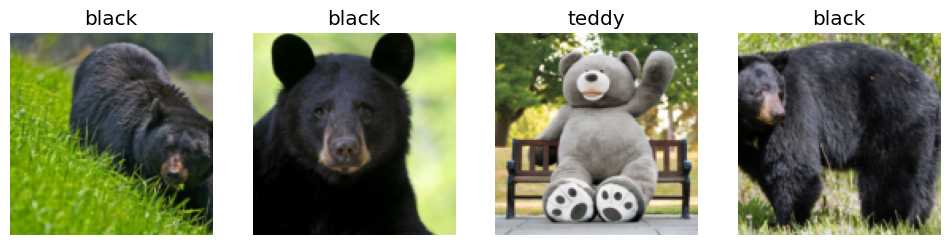

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

デフォルトでは `Resize` は、要求されたサイズの正方形に収まるように、幅または高さをフルに使って画像を *切り取る* 。その結果、重要なディテールが失われることがある。また、fastaiに頼んで、画像をゼロ（黒）で埋めるか、縮小・伸張させることかを選択できる：

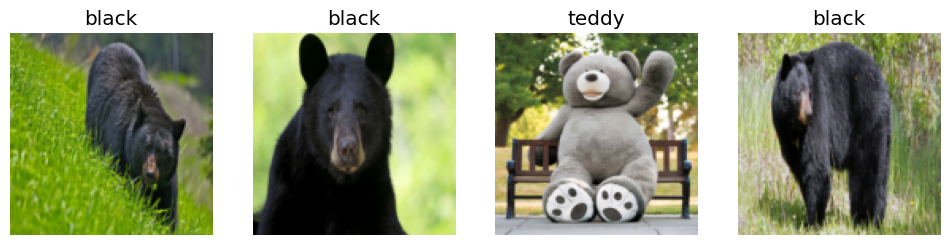

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

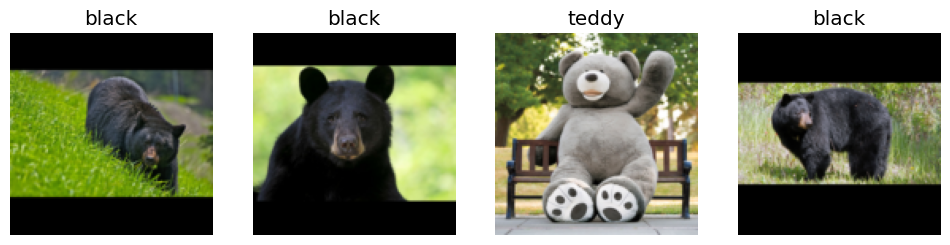

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

これらのアプローチは、いずれも無駄が多く、問題があるように思える。画像を縮小したり引き伸ばしたりすると、非現実的な形になってしまい、物事が実際と違って見えることを学習するモデルになってしまうので、精度が落ちることが予想される。また、画像を切り抜くと、認識を行うための特徴が失われる。例えば、犬や猫の品種を認識しようとした場合、似たような品種を区別するために必要な体や顔の重要な部分を切り抜いてしまうかもしれない。このような場合、画像を脚色すると、空白部分が多くなり、モデルの計算が無駄になり、実際に使用する部分の解像度が低くなってしまう。

そのため、実際には画像の一部をランダムに選択し、その部分のみを切り取るという方法をとる。各エポック（データセットの全画像を1回完全に通過すること）では、各画像の異なる部分をランダムに選択する。これは、モデルが画像の異なる特徴に注目し、それを認識することを学習できることを意味する。これは、現実世界における画像の仕組みを反映したものだ。

実際、全く訓練されていないニューラルネットワークは、画像がどのように振る舞うかについて何も知らない。物体を1度回転させても、同じものの写真であることすら認識できない！なので物体の位置や大きさが微妙に異なる画像の例でニューラルネットワークを実際に訓練することで、物体とは何か、そしてそれを画像でどう表現できるかという基本的な概念を理解することになる。

ここでは、`Resize`を`RandomResizedCrop`に置き換えた別の例を示すが、これは先ほど説明した動作を提供する変換機能です。渡すべき最も重要なパラメータは `min_scale` で、これは毎回画像のどれだけの部分を最小で選択するかを決定する：

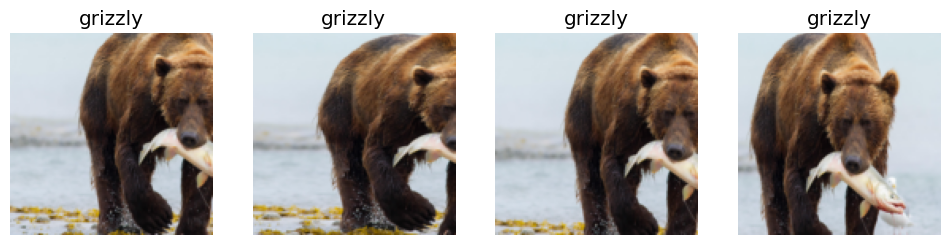

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

`unique=True`を使用して、同じ画像を異なるバージョンの `RandomResizedCrop` 変換で繰り返した。これは、データ拡張と呼ばれる、より一般的な手法の具体例だ。

### データ拡張

*データ拡張*とは、入力されたデータをランダムに変化させることで、見た目は異なるが、実際にはデータの意味を変えないようにすること。画像のデータ拡張の例としては、回転、反転、遠近法、明るさの変化、コントラストの変化などがある。ここで使っているような自然な写真画像については、かなりうまく機能することがわかっている標準的な拡張法セットが `aug_transforms` 関数で提供されている。画像はすべて同じサイズなので、GPUを使用してこれらの拡張をバッチ全体に適用することができ、時間を大幅に節約することができる。バッチに対してこれらの変換を使用したいことをfastaiに伝えるには、`batch_tfms`パラメータを使用する（この例では、違いがより明確にわかるように`RandomResizedCrop`を使用していないことに注意してほしい；同じ理由で、デフォルトと比較して2倍のオーグメントを使用している）：

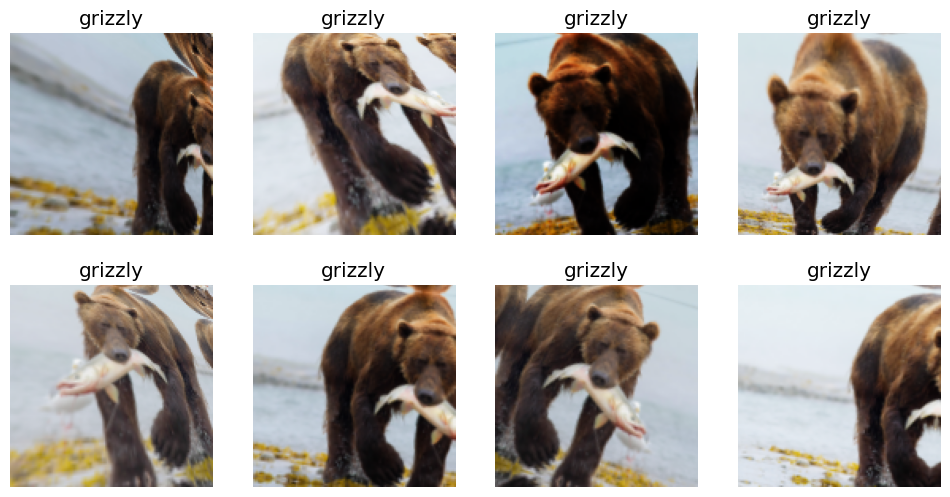

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

モデル学習に適した形でデータが揃ったので、実際にこれらを使って画像分類器を学習してみよう。

## モデルをトレーニングし、それを使ってデータをきれいに

それでは、<<chapter_intro>>と同じコードを使って、熊の分類器を訓練してみよう。

この課題のデータはそれほど多くない（せいぜいクマの種類ごとに150枚）ので、モデルを学習するために、画像サイズを224pxに設定した `RandomResizedCrop` と、画像分類としてはかなり標準的な `aug_transforms` をデフォルトで使用することにする：

In [34]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

これで `Learner` を作成し、いつもの方法で微調整を行う：

In [35]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

さて、このモデルが犯している間違いは、主にグリズリーベアをテディベアと思い込んでいるのか（それは安全性の観点上よくない！）、グリズリーベアをブラックベアと思い込んでいるのか、あるいはそれ以外のものなのかを見てみよう。これを視覚化するために、*混合行列*を作成する：

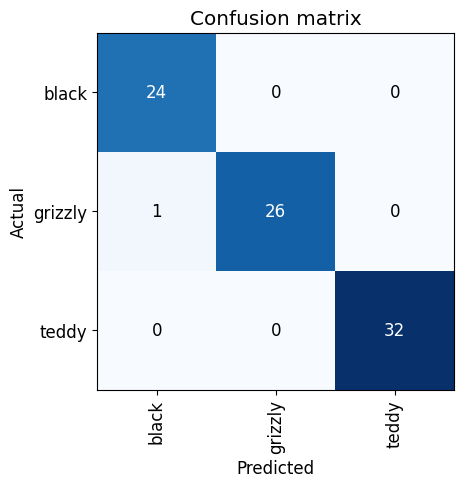

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

行列の行はデータセットに含まれるすべてのブラックベア、グリズリーベア、テディベアをそれぞれ表す。列は、モデルがそれぞれのクマと予測した画像を表している。したがって、行列の対角線は正しく分類された画像を示し、対角線外のセルは間違って分類された画像を示している。これは、fastaiがモデルの結果を表示するための多くの方法の1つである。これは（もちろん）検証セットを使って計算されたものだ。色分けでは、濃い青である対角線を除くすべての場所を白にするのが目標だ。われわれのクマ分類器は、あまり間違いを犯していないな！

上記のエラーがデータセットの問題（例：全くクマがない画像、ラベルが正しくない画像など）なのか、モデルの問題（異常な照明で撮影された画像、異なる角度から撮影された画像などを処理できていない）なのかを把握するために、正確にどこでエラーが発生しているかを確認するのが良い。そのために、画像を*損失*でソートすることにする。

損失は、モデルが不正解の場合（特に不正解にも自信がある場合）、または正解だが正解に自信がない場合に高くなる数値である。いくつかの章において、損失がどのように計算され、学習プロセスで使用されるかを詳しく学ぶ。とりあえず、`plot_top_losses`は、データセットの中で最も損失が大きい画像を示している。出力のタイトルにあるように、各画像には、予測、実測（ターゲットラベル）、損失、確率の4つがラベル付けされています。ここでいう*確率*とは、モデルが予測に対して割り当てた0から1までの信頼度です：

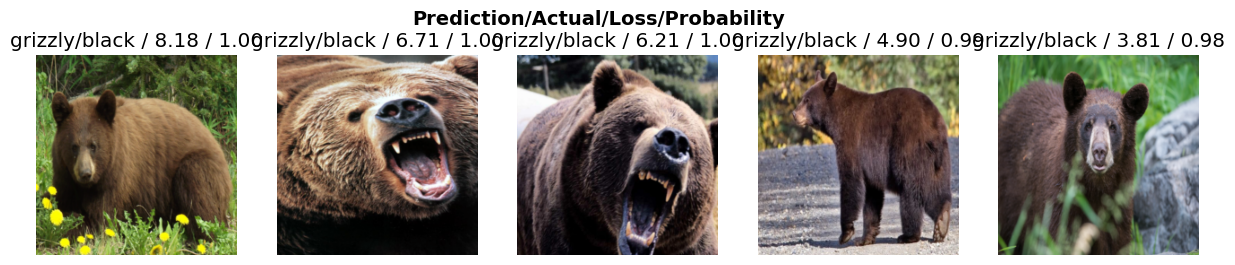

In [27]:
interp.plot_top_losses(5, nrows=1)

この出力から最も損失が大きい画像は、高い信頼性で「グリズリーベア」と予測されたものであることがわかる。しかし、この画像は（Bingの画像検索に基づき）"ブラックベア "とラベル付けされている。私たちは熊の専門家ではないが、このラベルは確かに間違っているように見える。このラベルを "グリズリーベア"に変えるべきだろう。

データクリーニングの直感的なアプローチは、モデルを訓練する前に行うことだ。しかし、このケースでお分かりのように、モデルは実際にデータの問題をより迅速かつ容易に見つけるのに役立つ。なので、私たちは通常、まず手軽で簡単なモデルを訓練し、それをデータクリーニングに役立てることを好む。

fastaiには、`ImageClassifierCleaner`というデータクリーニングのための便利なGUIがあり、カテゴリとトレーニングセットと検証セットを選択し、最も損失の大きい画像を（順番に）表示することができ、さらに画像を選択して削除や再ラベル化を行うことができるメニューがある：

In [37]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="https://github.com/fastai/fastbook/blob/master/images/att_00007.png?raw=1">

In [31]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

"ブラックベア"の中に、グリズリーベアとブラックベアの2頭の熊を含む画像があることがわかる。そこで、この画像の下にあるメニューから `<Delete>` を選択する。`ImageClassifierCleaner`は、実際にラベルの削除や変更を行うわけではなく、変更する項目のインデックスを返すだけだ。つまるところ例えば、削除対象として選択されたすべての画像を削除（`unlink`）するためには、次のように実行する(※柴田補足 画像選択してラベル変更した場合、下記のコードを実行しないままカテゴリ変更してしまうとリセットされるので注意)：

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

別のカテゴリーへと選択した画像を動かすには、以下を実行することになる：

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: データクリーニングとモデルの準備は、データサイエンティストにとって最大の課題の2つであり、時間の9割を占めると言われている。fastaiライブラリは、それをできるだけ簡単にするためのツールを提供することを目的としている。

本書では、モデル駆動型データクリーニングの例をもう少し多く紹介する。データのクリーニングが完了したら、モデルを再トレーニングしよう。実際に試してみて、精度が向上するかどうか確認してみてほしい！

> 注意: ビッグデータは不必要： この手順でデータセットをクリーニングした後、一般的にこのタスクの精度は100%になる。1クラスあたり150枚という少ない枚数の画像をダウンロードした場合でも、この結果を得ることができた。このように、「ディープラーニングを行うには大量のデータが必要だ」という一般的な謳い文句は、真実から大きくかけ離れている可能性がある！

さて、モデルのトレーニングが終わったところで、実際に使用するためにどのようにデプロイするか見てみよう。

## モデルをオンラインアプリケーション化する

このモデルを実際に動作するオンラインアプリケーションにするために必要なことを見ていく。この本では、ウェブアプリケーション開発の詳細をすべて説明することは出来ないので、基本的な動作するプロトタイプを作成するところまでとする。

### 推論にモデルを使う

満足のいくモデルができたら、それを保存して、本番で使用するサーバーにコピーする必要がある。モデルは2つの部分から構成されていることを覚えておいてほしい：*アーキテクチャ*と学習済み*パラメータ*だ。モデルを保存する最も簡単な方法は、これらの両方を保存することだ。そうすれば、モデルをロードするときに、アーキテクチャとパラメータが一致していることを確認できる。両方の部分を保存するには、`export`メソッドを使用する。

このメソッドは `DataLoaders` の作成方法に関する定義も保存している。これは重要だ。そうしないと、モデルを本番で使うためにデータを変換する方法を再定義しなければならないのである。fastaiはデフォルトで推論に検証セットの`DataLoader`を自動的に使用するので、データ拡張は適用されないが、これは一般的に望ましいことだろう。

`export`を呼び出すと、fastaiは "export.pkl"という名前のファイルを保存する：

In [38]:
learn.export()

Pythonの`Path`クラスにfastaiが追加した`ls`メソッドを使って、ファイルが存在するかどうか確認してみよう：

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

このファイルは、アプリをどこにデプロイするかに関わらず必要だ。とりあえず、ノートブックの中で簡単なアプリを作ってみよう。

予測値を得るためにモデルを使用する場合、訓練の代わりに *推論* と呼ぶ。エクスポートしたファイルから推論器を作成するには、`load_learner`を使用する（この場合、ノートブックにすでに動作する`Learner`があるので、これは本当は必要ではない；ここでは、全体のプロセスをend-to-endで見ることができるようにするためにやっているだけだ）：

In [40]:
learn_inf = load_learner(path/'export.pkl')

推論を行う場合、一般的には一度に1つの画像の予測値を得る。これを行うには、`predict`にファイル名を渡す：

In [41]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.7186e-06, 9.9999e-01, 6.1233e-06]))

これは、あなたが最初に渡したのと同じフォーマットで予測されたカテゴリ（この場合は文字列）、予測されたカテゴリのインデックス、および各カテゴリの確率の3つを返してきた。最後の2つは、`DataLoaders`の*vocab*にあるカテゴリの順序に基づいている; つまり、すべてのあり得るカテゴリのリストである。推論時には、`Learner`の属性として `DataLoaders` にアクセスすることができる：

In [42]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

ここで、`predict`が返す整数のインデックスを見てみると、予想通り「グリズリーベア」が返されていることがわかる。また、確率のリストにインデックスを付けると、これがグリズリーである確率はほぼ1.00であることがわかる。(※柴田注 9.9999e-01)

保存したモデルから予測を行う方法はわかっているので、アプリの構築を開始するのに必要なものはすべてそろった。Jupyter notebookで直接行うことができる。

### モデルからNotebookアプリを作成

このモデルをアプリケーションで使用するには、`predict`メソッドを通常の関数として扱えばよい。したがって、このモデルからアプリケーションを作成するには、アプリケーション開発者が利用できる無数のフレームワークやテクニックを使用することができる。

しかし、ほとんどのデータサイエンティストは、ウェブアプリケーション開発の世界には精通していない。そこで、この時点で知っているものを使ってみることにする。Jupyterノートブックだけで、完全に動作するWebアプリケーションを作成できるのだ！これを実現するために必要なものは2つ：

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets*は、JavaScriptとPythonの機能をWebブラウザ上でまとめるGUIコンポーネントで、Jupyterノートブック内で作成・使用することができる。例えば、本章の前半で見たイメージクリーナーは、すべてIPythonウィジェットで書かれている。しかし、このアプリケーションの利用者にJupyterを自分で起動させることを求めたいわけではない。

そのために*Voilà*が存在するのだ。これは、IPythonウィジェットで構成されるアプリケーションを、Jupyterを使うことなくエンドユーザーに提供するためのシステムである。Voilàは、ノートブックがすでにWebアプリケーションの一種であるという事実を利用している。ただし、別のWebアプリケーションに依存するため少し複雑なのである： 何を隠そうJupyterそのものだ。基本的には、私たちがすでに暗黙のうちに作った複雑なWebアプリケーション（ノートブック）を、よりシンプルでデプロイしやすいWebアプリケーションに自動的に変換してくれるもので、ノートブックのような機能ではなく、通常のWebアプリケーションのように機能する。

しかし、ノートブックで開発するという利点は残っているので、ipywidgetsを使えば、GUIを段階的に作り上げていくことができる。この方法を用いて、簡単な画像分類器を作成する。まず、ファイルアップロードウィジェットが必要だ：

In [43]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

画像を取得:

In [44]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [45]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

それを表示するには `Output` ウィジェットを利用できる：

In [46]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

そうすれば、予測を得ることができる:

In [47]:
pred,pred_idx,probs = learn_inf.predict(img)

そしてそれを表示するために `Label` を使用する：

In [48]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

`Prediction: grizzly; Probability: 1.0000`

分類を行うためのボタンが必要だ。アップロードボタンと全く同じような感じで：

In [49]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

また、*クリックイベントハンドラー*も必要だ。つまり、押されたときに呼び出される関数です。上のコードの行をそのままコピーすればいい：

In [50]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

ボタンを押すと、画像と予測が自動的に更新されるのを確認できるはず！

あとは、これらを縦長の箱（`VBox`）に入れれば、GUIの完成だ：

In [51]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [52]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="https://github.com/fastai/fastbook/blob/master/images/att_00011.png?raw=1">

アプリに必要なコードはすべて書いた。次のステップは、これをデプロイできるようなものに変換することである。

### Notebookを真のアプリへ

In [53]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


さて、このJupyterノートブックですべてが動作するようになったので、アプリケーションを作成することができる。新しいノートブックを作成し、必要なウィジェットを作成・表示するためのコードと、表示させたいテキストのマークダウンのみを追加する。この本のリポジトリにある *bear_classifier* ノートブックを見て、私たちが作った簡単なノートブック・アプリケーションを見てみてほしい。

次に、まだインストールされていない方は、以下の行をノートブックのセルにコピーして実行し、Voilàをインストールしよう：

    !pip install voila
    !jupyter serverextension enable --sys-prefix voila

"!"で始まるセルにはPythonのコードは含まれておらず、代わりにシェル（bash、Windows PowerShellなど）に渡されるコードが含まれている。本書の後半で詳しく説明しするが、コマンドラインの使用に慣れているのであれば、もちろんこの2行を（接頭辞 `!` を付けずに）ターミナルに直接入力するだけでも構わない。この場合、1行目は`voila`ライブラリとアプリケーションをインストールし、2行目はそれを既存のJupyterノートブックに接続することを意味する。

Voilàは、あなたが今使っているJupyterノートブックサーバと同じようにJupyterノートブックを実行するが、同時にとても重要なことを行う。それは、セルの入力をすべて削除し、マークダウンセルに従って出力（ipywidgetsを含む）のみを表示することだ。つまり、残るはウェブアプリケーションだ！あなたのノートブックをVoilàウェブアプリケーションとして表示するには、ブラウザのURLで "notebooks "という単語を次のように置き換える： "voila/render "と書き換える。ノートブックと同じ内容が表示されるが、コードのセルはない。

もちろん、Voilàやipywidgetsを使う必要はない。モデルは単に呼び出せる関数（`pred,pred_idx,probs = learn.predict(img)` ）なので、どんなフレームワークでも、どんなプラットフォームでホストされていても使うことができるのだ。また、ipywidgetsやVoilàでプロトタイプを作成したものを、後で通常のWebアプリケーションに変換することもできる。本書でこの方法を紹介しているのは、データサイエンティストやウェブ開発の専門家ではない人たちが、モデルからアプリケーションを作成するのに最適な方法だと考えているからだ。

アプリができたので、デプロイしてみよう！

### アプリをデプロイする

ご存知の通り、ほぼすべての有用なディープラーニングモデルをトレーニングするためには、GPUが必要だ。では、そのモデルを本番で使うのにGPUは必要だろうか？正解はいいえだ！ほぼ間違いなく、本番環境でモデルを使用するためにGPUは必要ない*。これにはいくつかの理由がある：

- これまで見てきたように、GPUが有用なのは同じ作業を大量に並行して行う場合だけである。例えば、画像の分類を行う場合、通常は一度に一人のユーザーの画像を分類することになるし、一枚の画像で行う作業においてはGPUを忙しく動かすくらいの仕事量はない。そのため、CPUの方が費用対効果が高い場合が多い。
- 数人のユーザーが画像を投稿するのを待ち、それをバッチ処理してGPUで一度に処理する方法もある。しかし、それではユーザーに待ってもらうことになり、すぐに答えが出るわけではない！また、この機能を実現するためには、大容量のサイトが必要となる。この機能が必要な場合は、Microsoftの[ONNX Runtime](https://github.com/microsoft/onnxruntime)や[AWS Sagemaker](https://aws.amazon.com/sagemaker/)などのツールを使用することができる。
- GPU推論を扱うことの複雑さは相当なものだ。特に、GPUのメモリは手動で慎重に管理する必要があり、一度に1つのバッチしか処理しないように、慎重にクエリシステムを用意する必要がある。
- CPUサーバーはGPUサーバーよりも市場競争が激しく、その結果、CPUサーバーにはより安価なオプションが用意されている。

GPUの処理は複雑であるため、これを自動化しようとするシステムが数多く登場している。しかし、これらのシステムの管理・運用も複雑で、一般的には、そのシステム用に特化した別の形式にモデルをコンパイルする必要があるのだ。このような複雑な処理は、アプリが十分に普及し、そうすることが経済的に明らかに意味を持つようになるまで、あるいはそうでない限り、通常は避けることが望ましい。

少なくともアプリケーションの初期プロトタイプや、見せびらかしたい趣味のプロジェクトであれば、簡単に無料でホストすることができる。最適な場所や方法は時代によって変わるので、[本のウェブサイト](https://book.fast.ai/)で最新の推奨事項を確認してほしい。本書を執筆している2020年初頭の時点では、最もシンプルな（そして無料の！）アプローチは[Binder](https://mybinder.org/)を使用することだ。BinderでWebアプリを公開するには、以下のステップを踏む：

1. ノートブックを[GitHubリポジトリ](http://github.com/)に追加する。
2. <<deploy-binder>> のように、BinderのURLにそのリポジトリのURLを貼り付ける。
3. [ファイル]のドロップダウンを[URL]に変更します。
4. "URL to open "フィールドに、`/voila/render/name.ipynb`（`name`はノートブックの名前に置き換える）を入力する。
5. 右下のクリックボードボタンをクリックしてURLをコピーし、安全な場所に貼り付ける。
6. Launchをクリック。

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

最初にこれを行う際は、Binderであなたのサイトを構築するためには5分程度かかる。舞台裏では、アプリを実行できる仮想マシンを見つけ、ストレージを割り当て、Jupyterやノートブックに必要なファイルを収集し、ノートブックをWebアプリケーションとして表示するための作業を行っている。

最後に、アプリの実行を開始すると、ブラウザを新しいウェブアプリに案内する。コピーしたURLを共有することで、他の人があなたのアプリにアクセスできるようにすることができるのだ。

Webアプリをデプロイするための他の（無料と有料の）オプションについては、[本のウェブサイト](https://book.fast.ai/)をぜひ見てみてほしい。

アプリケーションをモバイルデバイスやRaspberry Piのようなエッジデバイスにデプロイしたいと思うこともあるだろう。モデルをモバイルアプリケーションに直接統合できるライブラリやフレームワークもたくさんある。しかし、これらのアプローチは、多くの余分なステップや定型文を必要とする傾向があり、モデルが使用する可能性のあるすべてのPyTorchやfastaiレイヤーを常にサポートしているわけではない。さらに、iOSデバイスで動作させるために必要な作業、新しいAndroidデバイスで動作させるために必要な作業、古いAndroidデバイスのために必要な作業など、どのようなモバイルデバイスをターゲットとして展開するかによって、作業内容が変わってくる。なので代わりに、可能な限り、モデル自体をサーバーにデプロイし、モバイルアプリケーションやエッジアプリケーションがウェブサービスとしてそれに接続できるようにすることをお勧めする。

この方法には、多くの利点があります。最初のインストールは簡単で、小さなGUIアプリケーションを配備するだけで、サーバーに接続してすべての作業を行うことができるからである。さらに重要なのは、コアロジックのアップグレードを、すべてのユーザーに配布するのではなく、サーバー上で行うことができることだ。サーバーには、多くのエッジデバイスよりも多くのメモリと処理能力があり、モデルの要求が高くなった場合にリソースを拡張することがはるかに容易なのだ。また、サーバーに搭載されるハードウェアは標準的なもので、fastaiやPyTorchがサポートしやすいので、モデルを別の形にコンパイルする必要がない。

もちろん、デメリットもある。アプリケーションにはネットワーク接続が必要で、モデルが呼び出されるたびに多少の待ち時間が発生する。(ニューラルネットワークモデルの実行には時間がかかるため、このようなネットワークの遅延は、実際にはユーザーにとって大きな違いとはならないかもしれない。実際、サーバーではより良いハードウェアを使用できるため、全体的なレイテンシはローカルで実行する場合よりも小さくなる可能性がある!） また、アプリケーションが機密データを使用する場合、ユーザーはそのデータをリモートサーバーに送信する方法に懸念を抱く可能性がある。一方、エッジデバイス上でモデルを実行する場合、各ユーザーが自分のコンピュートリソースを持ち込むことになるので、ユーザー数の増加に伴うスケーリングが容易になる（*水平スケーリング*とも呼ばれる）。

> A: 私は仕事柄、モバイルMLの状況がどのように変化しているかを間近で見る機会がああった。私たちは、コンピュータ・ビジョンに依存するiPhoneアプリを提供しているが、何年もの間、私たち自身のコンピュータ・ビジョン・モデルをクラウド上で実行していた。なぜなら、これらのモデルはかなりのメモリと計算資源を必要とし、入力を処理するのに数分かかるからだ。このアプローチでは、モデル（楽しい！）の知識だけでなく、一定数の「コンピュートワーカーマシン」が絶対に常に稼働していること（怖い）、トラフィックが増加すれば自動的にマシンが増えること、大きな入力と出力に対して安定したストレージがあること、iOSアプリが自分の仕事がどうなっているかをユーザーに伝えられることなど、インフラの構築の知識も必要だった。現在では、Appleがモデルをデバイス上で効率的に実行できるように変換するためのAPIを提供し、ほとんどのiOSデバイスがML専用のハードウェアを備えている。それでもまだ簡単ではないが、私たちの場合、より速いユーザー体験とサーバーの心配を減らすために価値はある。何が効果的かは、現実的には、作ろうとしているユーザー体験と、個人的にやりやすいと思うことに寄るだろう。もし、あなたが本当にサーバーを動かす方法を知っているなら、それを実行すればいい。ネイティブのモバイルアプリの作り方を本当に知っているのなら、それをやればいい。坂の上にはたくさんの道がある。

結論として、可能な限りシンプルなCPUベースのサーバーアプローチを使用することをお勧めする。もし幸運にもアプリケーションが大成功を収めれば、その時点でより複雑なデプロイメントアプローチへの投資を正当化できるようになるはずだ。

おめでとう、あなたはディープラーニングモデルを構築し、それをデプロイすることに成功した！今一度立ち止まって、問題点を洗い出す良い機会だ。

私たちの生徒が、この教材の理解を深めるために最も役立っていることのひとつが、書き出すことだ。誰かに教えようとすることほど、自分の理解を試すのに最適なことはない。書いたものを誰かに見せることはなくても、共有することで、より理解を深めることができる！だから、まだの方は、ブログを始めることをお勧めする。第2章を終え、モデルのトレーニングやデプロイの方法を学んだあなたは、ディープラーニングの旅について最初のブログ記事を書くのに十分な環境にある。驚いたことは何か？あなたの分野では、深層学習のどんな機会があると思うか？また、どのような障害があると思うか？

fast.aiの共同創業者であるレイチェル・トーマスは、記事の中で次のように書いている。 ["Why You (Yes, You) Should Blog"](https://medium.com/@racheltho/why-you-yes-you-should-blog-7d2544ac1045):

```asciidoc
____
私が若い頃の自分にしたいアドバイスは、もっと早くブログを始めることだ。ブログを書く理由は以下の通り：

* より良い履歴書のようなものだ。私は、ブログの投稿が仕事のオファーにつながった人を何人か知っている！
* 学ぶことができる。知識を整理することは、常に自分の考えをまとめるのに役立つ。自分が何かを理解しているかどうかのテストのひとつは、それを誰かに説明できるかどうかだ。ブログ記事は、そのための素晴らしい方法である。
* 私は、自分のブログ記事からカンファレンスへの招待や講演の依頼を受けたことがある。TensorFlowが好きではないというブログ記事を書いたことで、TensorFlow Dev Summitに招待された（最高だった！）。
* 新しい人に会える。私が書いたブログ記事に反応してくれた人たちに何人か会った。
* 時間を節約することができる。メールで何度も質問に答えるときは、それをブログ記事にしておくと、次に誰かが質問してきたときに共有しやすくなる。
____
```

彼女の最も重要なアドバイスは、おそらくこれだ。: 

> : あなたは、自分の一歩後ろにいる人たちを助けるのに最も適した立場にいる。あなたの頭の中には、まだ教材が新鮮に残っている。多くの専門家は、初心者の頃（あるいは中級者）のことを忘れ、初めて聞く話題がなぜ理解しにくいのかを忘れてしまっている。あなたの特別な背景、あなたの特別なスタイル、あなたの知識レベルという文脈は、あなたが書いていることに違ったひねりを与えてくれるのだ。

ブログの開設方法については、<<appendix_blog>>で詳しく解説している。もしまだブログを持っていないのであれば、今すぐ見てみてほしい！

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

1. 学習データの構造的または様式的な違いにより、熊の分類モデルが本番でうまく機能しない可能性がある例を挙げてください。
1. テキストモデルは現在、どこに大きな欠陥があるのか？
1. テキスト生成モデルの社会的な負の影響にはどのようなものが考えられるか？
1. モデルが間違いを犯す可能性があり、その間違いが有害である可能性がある状況において、プロセスを自動化することの良い代替案は何ですか？
1. ディープラーニングが特に得意とする表形式のデータとはどのようなものですか？
1. ディープラーニングモデルを推薦システムに直接使用することの重要な欠点は何ですか？
1. Drivetrain Approachのステップは？
1. Drivetrain Approachのステップは、どのようにレコメンデーションシステムに対応するのか？
1. キュレーションしたデータを使って画像認識モデルを作成し、Web上に展開する。
1. DataLoaders`とは何ですか？
1. DataLoaders`を作成するためにfastaiに伝えるべき4つのこととは？
1. DataBlock` の `splitter` パラメータは何をするのか？
1. ランダムな分割で常に同じ検証セットを得られるようにするにはどうすればよいですか？
1. 独立変数と従属変数を表すのによく使われる文字は何ですか？
1. クロップ、パッド、スクイッシュのリサイズアプローチの違いは何ですか？どのような場合に、他の方法より1つを選択するのでしょうか？
1. データ補強とは何ですか？なぜ必要なのでしょうか？
1. item_tfms`とbatch_tfms`の違いは何ですか？
1. 混同行列とは何ですか？
1. export`は何を保存するのですか？
1. トレーニングではなく、予測値を得るためにモデルを使用することを何と呼ぶか？
1. IPythonのウィジェットとは何ですか？
1. デプロイにCPUを使うのはどんなときか？GPUの方がいいのはどんなとき？
1. アプリを電話やPCなどのクライアント（エッジ）デバイスではなく、サーバーにデプロイすることのデメリットは何でしょうか？
1. 熊出没注意システムを実際に展開する際に発生しうる問題の例を3つ教えてください。
1. ドメイン外データ」とは何ですか？
1. ドメインシフト」とは何ですか？
1. デプロイメントプロセスの3つのステップとは何ですか？

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.